Learning rate = 0.01
epoch 15
Optimizer = Adam
Model - MobileNet
images - rgb with full range value without normalization
three layes added at top - dense(1000), dropout, dense

In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import PIL
import os

import matplotlib.pylab as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
data_dir = pathlib.Path("./final_dataset/")
data_dir

PosixPath('final_dataset')

# Preprocessing

## Read image files

In [3]:
from matplotlib import path
data_images_dict = {
    'Mask': list(data_dir.glob('**/mask/*')),
    'Improper Mask': list(data_dir.glob('**/improper_mask/*')),
    'Non Mask': list(data_dir.glob('**/no_mask/*'))
}

In [4]:
data_labels_dict = {
    'Mask': 0,
    'Improper Mask': 1,
    'Non Mask': 2
}

## Image to CSV

In [5]:
X, y = [], []

for image_name, images in data_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(data_labels_dict[image_name])

In [6]:
X = np.array(X)
y = np.array(y)

# Visualization

# Model training

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [9]:
IMAGE_SHAPE=(224,224)

In [10]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

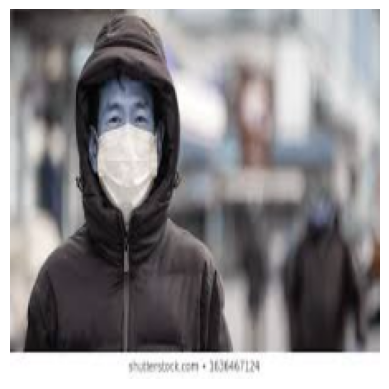

In [11]:
plt.axis('off')
plt.imshow(X[500])

In [12]:
pretrained_model_without_top_layer = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), alpha=1.0, include_top=False, weights='imagenet',
    input_tensor=None, pooling="avg")

In [13]:
for layers in pretrained_model_without_top_layer.layers:
  layers.trainable = False

In [14]:
num_of_classes = 3

model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(1000),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 1000)              1281000   
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                        

In [15]:
model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.000001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [16]:
weight_dir = "weights/50_epoch_mobilenetv2_more_layers_LR_LOW"
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
    
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_dir+'/checkpoint-{epoch:02d}.hdf5')

In [17]:
# history = model.fit(X_train_scaled, y_train, epochs=15,initial_epoch=11,callbacks=[checkpoint])
history = model.fit(X_train_scaled, y_train, epochs=50,callbacks=[checkpoint],validation_split=0.20,batch_size=10)

Epoch 1/50


2022-12-06 21:30:05.939908: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


573/573 [==============================] - 64s 108ms/step - loss: 1.1060 - acc: 0.5469 - val_loss: 0.6080 - val_acc: 0.7605
Epoch 2/50
573/573 [==============================] - 55s 96ms/step - loss: 0.7376 - acc: 0.6964 - val_loss: 0.3939 - val_acc: 0.8527
Epoch 3/50
573/573 [==============================] - 57s 99ms/step - loss: 0.5535 - acc: 0.7770 - val_loss: 0.2835 - val_acc: 0.8925
Epoch 4/50
573/573 [==============================] - 62s 108ms/step - loss: 0.4618 - acc: 0.8168 - val_loss: 0.2263 - val_acc: 0.9134
Epoch 5/50
573/573 [==============================] - 59s 103ms/step - loss: 0.3995 - acc: 0.8430 - val_loss: 0.1891 - val_acc: 0.9316
Epoch 6/50
573/573 [==============================] - 60s 105ms/step - loss: 0.3750 - acc: 0.8552 - val_loss: 0.1632 - val_acc: 0.9434
Epoch 7/50
573/573 [==============================] - 58s 102ms/step - loss: 0.3253 - acc: 0.8752 - val_loss: 0.1395 - val_acc: 0.9518
Epoch 8/50
573/573 [==============================] - 57s 100ms/step

In [18]:
model.evaluate(X_test_scaled,y_test)

56/56 [==============================] - 13s 228ms/step - loss: 0.0454 - acc: 0.9866


[0.04535973444581032, 0.986592173576355]

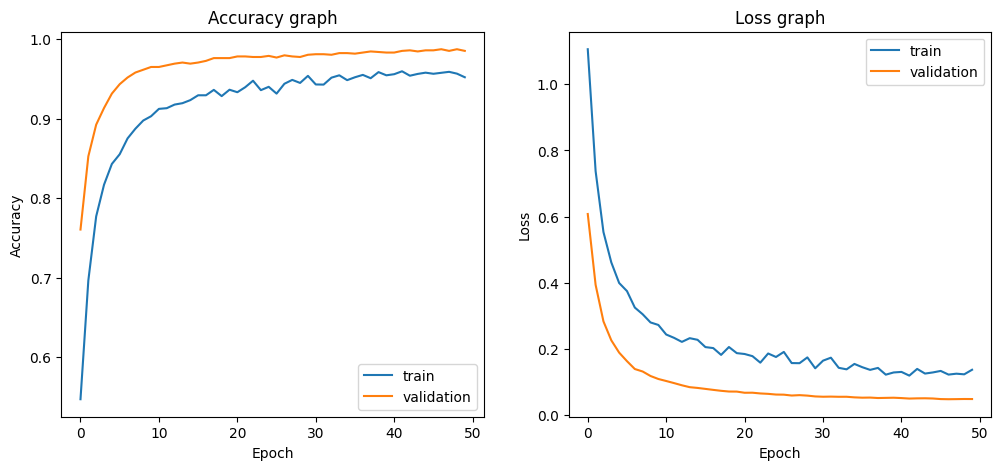

In [19]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
axs[0].plot(history.history['acc'])
axs[0].plot(history.history['val_acc'])
axs[0].set_title('Accuracy graph')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['train','validation'])

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Loss graph')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['train','validation'])

plt.show()

In [20]:
model.predict(X_test_scaled[0].reshape(1,224,224,3))

1/1 [==============================] - 1s 545ms/step


array([[-5.214947  , -0.43651056,  8.767827  ]], dtype=float32)

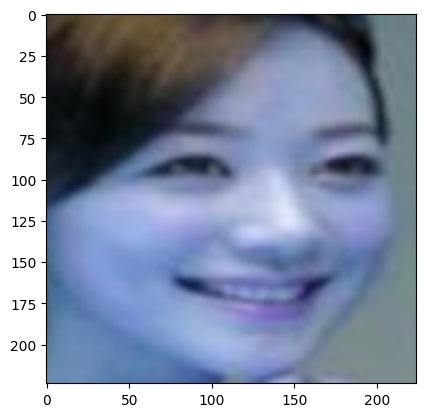

In [21]:
plt.imshow(X_test[0])

In [22]:
y_test[0]

2

In [23]:
type(history)

keras.callbacks.History

In [25]:
import pandas as pd
h = pd.DataFrame(history.history)

In [26]:
h.to_csv('history_mobilenetv2_more_layer_50_epoch.csv')

In [29]:
history1 = model.fit(X_train_scaled, y_train, epochs=60,initial_epoch=50,callbacks=[checkpoint],validation_split=0.20,batch_size=10)

Epoch 51/60
573/573 [==============================] - 59s 102ms/step - loss: 0.1155 - acc: 0.9621 - val_loss: 0.0476 - val_acc: 0.9874
Epoch 52/60
573/573 [==============================] - 52s 91ms/step - loss: 0.1267 - acc: 0.9577 - val_loss: 0.0473 - val_acc: 0.9867
Epoch 53/60
573/573 [==============================] - 54s 94ms/step - loss: 0.1406 - acc: 0.9532 - val_loss: 0.0476 - val_acc: 0.9853
Epoch 54/60
573/573 [==============================] - 54s 94ms/step - loss: 0.1290 - acc: 0.9579 - val_loss: 0.0484 - val_acc: 0.9867
Epoch 55/60
573/573 [==============================] - 56s 97ms/step - loss: 0.1184 - acc: 0.9623 - val_loss: 0.0466 - val_acc: 0.9860
Epoch 56/60
573/573 [==============================] - 55s 96ms/step - loss: 0.1106 - acc: 0.9635 - val_loss: 0.0464 - val_acc: 0.9867
Epoch 57/60
573/573 [==============================] - 55s 96ms/step - loss: 0.1108 - acc: 0.9630 - val_loss: 0.0470 - val_acc: 0.9874
Epoch 58/60
573/573 [==============================] -

In [ ]:
model = keras.models.load_model("./wcheckpoint-50.hdf5")

In [ ]:
y_pred = model.evaluate(X_test_scaled,y_test)

In [ ]:
import sklearn

sklearn.metrics.classification_report(y_true, y_pred)